In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, FreqDist, regexp_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.collocations import BigramAssocMeasures
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from gensim.models import word2vec
from spellchecker import SpellChecker
from collections import Counter
import string
import re
%matplotlib inline

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/morgandj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/morgandj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Exploration #

In [3]:
file='movie.csv'
df=pd.read_csv(file)

In [4]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
df['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [6]:
text=df['text'].str.lower()
labels=df['label']
X_train, X_test, y_train, y_test = train_test_split(text,labels,test_size=.2,random_state=20)

In [7]:
X_train.head()

36862    ok, here it is: "nazi mountaineer befriends th...
11768    romance is in the air and love is in bloom in ...
36393    this film is described as a action/comedy. the...
12031    i love the satan pit!!! david tennant is such ...
27211    i could never stand watching happy days after ...
Name: text, dtype: object

In [8]:
stopwords_list=stopwords.words('english')
stopwords_list.append('br')
remove=['up','down','didn',"didn't",'wasn',"wasn't",'wouldn',"wouldn't"]
for word in remove:
    stopwords_list.remove(word)

### Tokenize ###

In [9]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

tokenizer=RegexpTokenizer(pattern)
tokenized_train=X_train.apply(tokenizer.tokenize)

In [10]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [11]:
ns_tk_train=tokenized_train.apply(remove_stopwords)

In [12]:
tokenized_train.head()

36862    [ok, here, it, is, nazi, mountaineer, befriend...
11768    [romance, is, in, the, air, and, love, is, in,...
36393    [this, film, is, described, as, a, action, com...
12031    [i, love, the, satan, pit, david, tennant, is,...
27211    [i, could, never, stand, watching, happy, days...
Name: text, dtype: object

In [13]:
ns_tk_train.head()

36862    [ok, nazi, mountaineer, befriends, dalai, lama...
11768    [romance, air, love, bloom, victorian, era, en...
36393    [film, described, action, comedy, first, minut...
12031    [love, satan, pit, david, tennant, great, acto...
27211    [could, never, stand, watching, happy, days, c...
Name: text, dtype: object

In [14]:
new_df=pd.concat([tokenized_train,ns_tk_train,y_train],axis=1)
new_df.columns=['token','no-stop','label']

In [15]:
pos_reviews=new_df[new_df['label']==1]
neg_reviews=new_df[new_df['label']==0]

In [16]:
#Get Freq distributions for tokens w/ and w/o stopwords and compare top words
pos_freq = FreqDist(pos_reviews['token'].explode()).most_common(10)
pos_ns_freq = FreqDist(pos_reviews['no-stop'].explode()).most_common(10)
neg_freq = FreqDist(neg_reviews['token'].explode()).most_common(10)
neg_ns_freq = FreqDist(neg_reviews['no-stop'].explode()).most_common(10)
freqs=[pos_freq,pos_ns_freq,neg_freq,neg_ns_freq]

In [17]:
#total number of words in all reviews after stop words removed
fd=FreqDist(new_df['no-stop'].explode())
len(fd)

90425

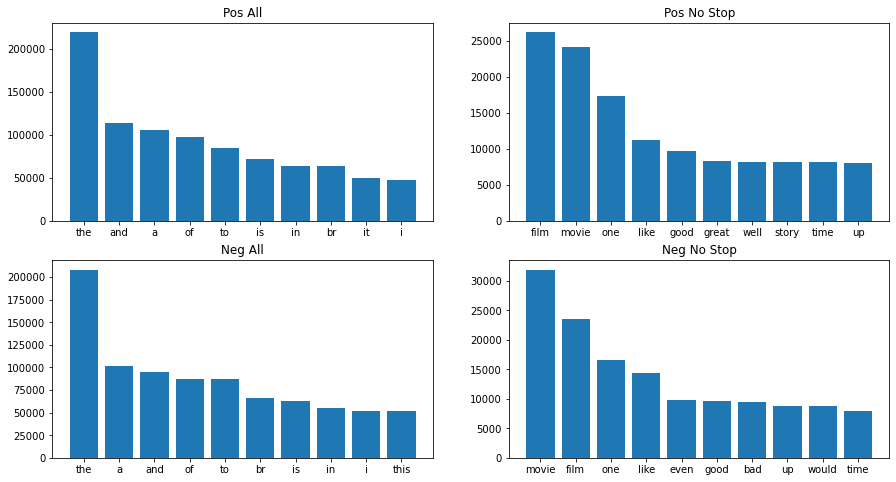

In [18]:
#Plot distributions for comparison
fig,axes=plt.subplots(2,2,figsize=(15,8))
titles=['Pos All','Pos No Stop','Neg All','Neg No Stop']

for count,ax in enumerate(axes.flatten()):
    x=[tup[0] for tup in freqs[count]]
    y=[tup[1] for tup in freqs[count]]
    ax.bar(x,y)
    ax.set_title(titles[count])


Need to investigate the token 'br'. Probably denotes a line break and shouldn't be included.

It appears that removing stop words helps differentiate between pos and neg reviews.  However, many of the top ten words are the same so we will need to train the model on a larger selection.  After removing stop words there are over 90k words in all the ratings so we will have to find a balance between reducing dimensionality and including enough training info.

In [19]:
new_df['contains_br']=new_df['no-stop'].apply(lambda x: 1 if 'br' in x else 0)
contains_br=new_df[new_df['contains_br']==1]
contains_br.head()

,token,no-stop,label,contains_br


Its clear that br is indicating line breaks. We'll remove this from all the token lists.

In [20]:
tokens_train=ns_tk_train.apply(lambda tok_list: [tok for tok in tok_list if tok!='br'])

Text(0.5, 1.0, 'negative')

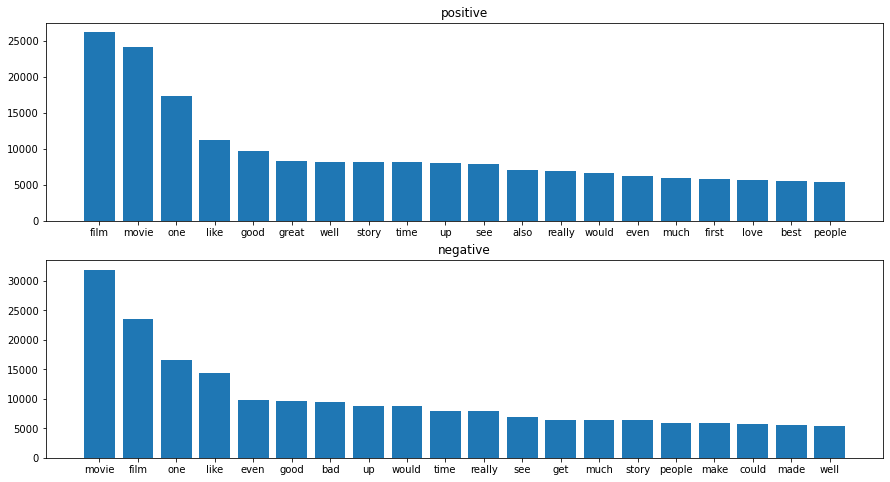

In [21]:
#redo top freq charts
tok_df=pd.concat([tokens_train,y_train],axis=1)
tok_df.columns=['token','label']
pos=tok_df[tok_df['label']==1]
neg=tok_df[tok_df['label']==0]
pos_fd=FreqDist(pos['token'].explode()).most_common(20)
neg_fd=FreqDist(neg['token'].explode()).most_common(20)

fig,axes=plt.subplots(2,figsize=(15,8))

pos_x=[tup[0] for tup in pos_fd]
pos_y=[tup[1] for tup in pos_fd]
neg_x=[tup[0] for tup in neg_fd]
neg_y=[tup[1] for tup in neg_fd]

axes[0].bar(pos_x,pos_y)
axes[0].set_title('positive')
axes[1].bar(neg_x,neg_y)
axes[1].set_title('negative')

There is not a huge difference between the top 20 words in the corpus. We'll use more for the model, but this could also indicate the importance of using bigrams to indicate how words are used together or using sequences.

# Preprocess

In [22]:
def correct_spelling(tokens):
    spell=SpellChecker()
    fixed=[spell.correction(t) if len(spell.unknown([t]))>0 else t for t in tokens]
    return fixed

In [23]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [24]:
glove=
w2v=W2vVectorizer()

SyntaxError: invalid syntax (<ipython-input-24-a123f98cfa53>, line 1)

In [ ]:
class Preprocess(object):
    
    def __init__(self, 
                 vector='count', 
                 stemming=None,
                 spell_check=False,
                n_grams=(1,1),
                max_df=1.0,
                 max_feat=None,
                chi_percent=None,
                glove_file=None):
        #defines how the text will be preprocessed
        
        self.vector_ = vector 
        #can be 'count','tfidf',or 'embedding'
        self.stemming_=stemming
        #can be 'None','stem','lemmatize'
        self.spell_check_=spell_check
        #True or False
        self.n_grams_=n_grams
        #n_gram to pass to tokenizer like (1,1) or (1,2)
        self.max_df_=max_df
        #positive float less than or equal to 1.0, to pass to vectorizer
        self.max_features_=max_feat
        self.chi_percent_=chi_percent
        #positive integer less than 100, percent features to keep if filtering with chi2
        #None if no filtering
        self.glove_file_=glove_file
        #None if using count or tfidf, glove file for word embeddings
         
    def fit(self, X, y):
        
        
        return self
            
    def tokenize(self,text):
        pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
        tokenizer=RegexpTokenizer(pattern)
        tokens=tokenizer.tokenize(text)
        
        if self.spell_check_==True:
            tokens=correct_spelling(tokens)
        
        if self.stemming_=='lemmatize':
            stems = []
            wnl=WordNetLemmatizer()
            for item in tokens:
                stems.append(wnl.lemmatize(item))
                
        elif self.stemming_=='stem':
            stems=[]
            stemmer=SnowballStemmer('english')
            for item in tokens:
                stems.append(stemmer.stem(item))
        
        else:
            stems=tokens
        return stems
    
    def filter_words_by_count(self,X,tokenized):
    
        vectorizer=CountVectorizer(stop_words=stopwords_list,
                                   max_df=self.max_df_,
                                   min_df=5)
        vectorizer.fit(X)

        #filter out words
        words_to_keep=vectorizer.vocabulary_.keys()
        filtered_data=tokenized.apply(lambda tok: [w for w in tok if w in words_to_keep])

        return filtered_data
    
    def build_glove(self,tokens):
        total_vocab=set([word for review in tokens for word in review])
        glove = {}
        #count=0
        #words=[]
        with open(self.glove_file_, 'rb') as f:
            for line in f:
                parts = line.split()
                word = parts[0].decode('utf-8')
                if word in total_vocab:
                    vector = np.array(parts[1:], dtype=np.float32)
                    glove[word] = vector
                    #count+=1
                    #words.append(word)
        return glove

    def transform(self, X, y):
        
        #tokenize according to inputs

        
        if self.vector_=='count':
            
            vectorizer=CountVectorizer(stop_words=stopwords_list,
                                       max_features=self.max_features_,
                                       tokenizer=self.tokenize,
                                       ngram_range=self.n_grams_,
                                       min_df=5,
                                       max_df=self.max_df_
                                      )
            tokens=vectorizer.fit_transform(X).toarray()
        
        elif self.vector_=='tfidf':
            
            vectorizer=TfidfVectorizer(stop_words=stopwords_list,
                                       max_features=self.max_features_,
                                       tokenizer=self.tokenize,
                                       ngram_range=self.n_grams_,
                                       min_df=5,
                                       max_df=self.max_df_
                                      )
            tokens=vectorizer.fit_transform(X).toarray()
            
        elif self.vector_=='embedding':
            tokenized=X.apply(self.tokenize)
            filtered=self.filter_words_by_count(X,tokenized)
            glove=self.build_glove(filtered)
            w2v=W2vVectorizer(glove)
            tokens=w2v.transform(filtered)
            
        if (self.chi_percent_ != None) and (self.vector_ != 'embedding'):
            
            selector=SelectPercentile(chi2,percentile=self.chi_percent_)
            selected=selector.fit_transform(tokens,y)
            tokens=selected
        
        return tokens


In [95]:
pp=Preprocess(vector='tfidf', 
                 stemming='stem',
                 spell_check=False,
                n_grams=(1,1),
                max_df=.5,
                chi_percent=None,
                glove_file='glove.6B.300d.txt')

train_tokens=pp.transform(X_train,y_train)


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [96]:
train_tokens.shape

(32000, 19934)

In [94]:
train_tokens

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06168705, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19312382, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [43]:
vectorizer=CountVectorizer(stop_words=stopwords_list,min_df=5,max_df=.3)
tokens_train=vectorizer.fit_transform(X_train).toarray()
tokens_train[0].sum()

167

In [44]:
tokens_train.shape

(32000, 30265)

# Baseline Model w/ Naive Bayes

In [21]:
#Create a train and validation set
train_X, val_X, train_y, val_y = train_test_split(X_train,
                                                  y_train,
                                                  test_size=.2,
                                                  random_state=40)

CountVectorizer will be used on original text with the desired characteristics outlined in the data exploration above in order to get the model features.

## Count Vectorization

In [23]:
vectorizer=CountVectorizer(stop_words=stopwords_list,max_features=10000)
tokens_train=vectorizer.fit_transform(X_train).toarray()

In [39]:
baseline=GaussianNB()
baseline.fit(tokens_train,y_train)

results=cross_val_score(baseline,tokens_train,y_train)
results

array([0.73828125, 0.75203125, 0.7396875 , 0.73375   , 0.7403125 ])

In [ ]:
#Try different max_features to see which has best results

In [40]:
max_to_try=[100,1000,5000,10000]
results={}

for m in max_to_try:
    vectorizer=CountVectorizer(stop_words=stopwords_list,max_features=m)
    tokens_train=vectorizer.fit_transform(X_train).toarray()
    
    baseline=GaussianNB()
    baseline.fit(tokens_train,y_train)

    results[m]=cross_val_score(baseline,tokens_train,y_train)
    
results

{100: array([0.68875   , 0.70234375, 0.69625   , 0.6840625 , 0.68328125]),
 1000: array([0.8103125 , 0.8125    , 0.80671875, 0.80390625, 0.8078125 ]),
 5000: array([0.73828125, 0.75203125, 0.7396875 , 0.73375   , 0.7403125 ]),
 10000: array([0.7171875 , 0.72625   , 0.7034375 , 0.70703125, 0.7203125 ])}

## TFIDF Vectorization

In [23]:
def correct_spelling(tokens):
    spell=SpellChecker()
    fixed=[spell.correction(t) if len(spell.unknown([t]))>0 else t for t in tokens]
    return fixed

In [24]:
test=['hredf','hi','doggy','mvie']
correct_spelling(test)

['red', 'hi', 'doggy', 'movie']

In [24]:
tfidf = TfidfVectorizer(max_features=1000,stop_words=stopwords_list)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train).toarray()

tfidf_model=GaussianNB()
tfidf_model.fit(X_train_vectorized,y_train)

results=cross_val_score(tfidf_model,X_train_vectorized,y_train)
results.mean()

0.81509375

In [39]:
max_to_try=[1000,15000]
results={}

for m in max_to_try:
    tfidf = TfidfVectorizer(max_features=m,stop_words=stopwords_list)
    X_train_vectorized = tfidf.fit_transform(X_train).toarray()

    tfidf_model=GaussianNB()
    tfidf_model.fit(X_train_vectorized,y_train)

    cv=cross_val_score(tfidf_model,X_train_vectorized,y_train)
    results[m]=cv.mean()
    
results

{1000: 0.81509375, 15000: 0.7502812500000001}

## Add Lemmatization

In [64]:
test=X_train[5]

In [25]:
#Custom tokenizer with Lemmatization
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

def tokenize(text):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer=RegexpTokenizer(pattern)
    tokens=tokenizer.tokenize(text)
    lemmas = []
    wnl=WordNetLemmatizer()
    for item in tokens:
        lemmas.append(wnl.lemmatize(item))
    return lemmas


In [71]:
#Custom tokenizer with Lemmatization
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

def tokenize(text):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer=RegexpTokenizer(pattern)
    tokens=tokenizer.tokenize(text)
    lemmas = []
    wnl=WordNetLemmatizer()
    for item in tokens:
        lemmas.append(wnl.lemmatize(item))
    return lemmas


In [72]:
X_train.apply(tokenize)

36862    [ok, here, it, is, nazi, mountaineer, befriend...
11768    [romance, is, in, the, air, and, love, is, in,...
36393    [this, film, is, described, a, a, action, come...
12031    [i, love, the, satan, pit, david, tennant, is,...
27211    [i, could, never, stand, watching, happy, day,...
                               ...                        
31962    [this, film, grab, you, from, the, opening, sc...
23452    [ok, so, it's, not, a, masterpiece, like, the,...
23775    [jefferey, dahmer, wa, one, sick, guy, there's...
37135    [unfortunately, this, ha, been, showing, on, s...
27098    [johnny, dangerously, fall, completely, in, th...
Name: text, Length: 32000, dtype: object

In [84]:
tfidf = TfidfVectorizer(max_features=1000,stop_words=stopwords_list,tokenizer=tokenize)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train).toarray()

tfidf_model=GaussianNB()
tfidf_model.fit(X_train_vectorized,y_train)

results=cross_val_score(tfidf_model,X_train_vectorized,y_train)
results.mean()

0.8108124999999999

Model actually performed slightly worse with lemmatization.

## Bigrams

In [1]:
tfidf = TfidfVectorizer(max_features=1000,
                        ngram_range=(1,2),
                        min_df=5,
                        max_df=.3,
                        stop_words=stopwords_list)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train).toarray()

tfidf_model=GaussianNB()
tfidf_model.fit(X_train_vectorized,y_train)

results=cross_val_score(tfidf_model,X_train_vectorized,y_train)
results.mean()

NameError: name 'TfidfVectorizer' is not defined

In [94]:
max_to_try=[1500,5000,7500,10000]
max_df_to_try=[.3,.5,.7]
results={}

for m in max_to_try:
    tfidf = TfidfVectorizer(max_features=m,
                        ngram_range=(1,2),
                        min_df=5,
                        max_df=.5,
                        stop_words=stopwords_list)
    X_train_vectorized = tfidf.fit_transform(X_train).toarray()

    tfidf_model=GaussianNB()
    tfidf_model.fit(X_train_vectorized,y_train)

    cv=cross_val_score(tfidf_model,X_train_vectorized,y_train)
    results[m]=cv.mean()
    
results

{1500: 0.82478125, 5000: 0.82659375, 7500: 0.8243124999999999, 10000: 0.8225}

In [99]:
ngrams=[(1,2),(2,2),(1,3),(3,3)]
max_to_try=[1500,5000,7500]
max_df_to_try=[.3,.5,.7]

results={}

for m in max_to_try:
    for d in max_df_to_try:
        for n in ngrams:
            tfidf = TfidfVectorizer(max_features=m,
                                ngram_range=n,
                                min_df=5,
                                max_df=d,
                                stop_words=stopwords_list)
            X_train_vectorized = tfidf.fit_transform(X_train).toarray()

            tfidf_model=GaussianNB()
            tfidf_model.fit(X_train_vectorized,y_train)

            cv=cross_val_score(tfidf_model,X_train_vectorized,y_train)
            results[(m,d,n)]=cv.mean()
    
results

{(1500, 0.3, (1, 2)): 0.8240000000000001,
 (1500, 0.3, (2, 2)): 0.7584375,
 (1500, 0.3, (1, 3)): 0.8240000000000001,
 (1500, 0.3, (3, 3)): 0.6346875000000001,
 (1500, 0.5, (1, 2)): 0.82478125,
 (1500, 0.5, (2, 2)): 0.7584375,
 (1500, 0.5, (1, 3)): 0.8243750000000001,
 (1500, 0.5, (3, 3)): 0.6346875000000001,
 (1500, 0.7, (1, 2)): 0.8252499999999999,
 (1500, 0.7, (2, 2)): 0.7584375,
 (1500, 0.7, (1, 3)): 0.8251875,
 (1500, 0.7, (3, 3)): 0.6346875000000001,
 (5000, 0.3, (1, 2)): 0.826,
 (5000, 0.3, (2, 2)): 0.792875,
 (5000, 0.3, (1, 3)): 0.8258749999999999,
 (5000, 0.3, (3, 3)): 0.669125,
 (5000, 0.5, (1, 2)): 0.82659375,
 (5000, 0.5, (2, 2)): 0.792875,
 (5000, 0.5, (1, 3)): 0.826125,
 (5000, 0.5, (3, 3)): 0.669125,
 (5000, 0.7, (1, 2)): 0.82596875,
 (5000, 0.7, (2, 2)): 0.792875,
 (5000, 0.7, (1, 3)): 0.8262812499999999,
 (5000, 0.7, (3, 3)): 0.669125,
 (7500, 0.3, (1, 2)): 0.82409375,
 (7500, 0.3, (2, 2)): 0.8011874999999999,
 (7500, 0.3, (1, 3)): 0.8240624999999999,
 (7500, 0.3, (3, 

In [107]:
sorted(list(zip(results.keys(),results.values())),key=lambda x:x[1],reverse=True)

[((5000, 0.5, (1, 2)), 0.82659375),
 ((5000, 0.7, (1, 3)), 0.8262812499999999),
 ((5000, 0.5, (1, 3)), 0.826125),
 ((5000, 0.3, (1, 2)), 0.826),
 ((5000, 0.7, (1, 2)), 0.82596875),
 ((5000, 0.3, (1, 3)), 0.8258749999999999),
 ((1500, 0.7, (1, 2)), 0.8252499999999999),
 ((1500, 0.7, (1, 3)), 0.8251875),
 ((1500, 0.5, (1, 2)), 0.82478125),
 ((1500, 0.5, (1, 3)), 0.8243750000000001),
 ((7500, 0.7, (1, 2)), 0.82434375),
 ((7500, 0.5, (1, 2)), 0.8243124999999999),
 ((7500, 0.3, (1, 2)), 0.82409375),
 ((7500, 0.3, (1, 3)), 0.8240624999999999),
 ((1500, 0.3, (1, 2)), 0.8240000000000001),
 ((1500, 0.3, (1, 3)), 0.8240000000000001),
 ((7500, 0.7, (1, 3)), 0.8237500000000001),
 ((7500, 0.5, (1, 3)), 0.82371875),
 ((7500, 0.3, (2, 2)), 0.8011874999999999),
 ((7500, 0.5, (2, 2)), 0.8011874999999999),
 ((7500, 0.7, (2, 2)), 0.8011874999999999),
 ((5000, 0.3, (2, 2)), 0.792875),
 ((5000, 0.5, (2, 2)), 0.792875),
 ((5000, 0.7, (2, 2)), 0.792875),
 ((1500, 0.3, (2, 2)), 0.7584375),
 ((1500, 0.5, (2, 2

In [25]:
ngrams=[(1,2),(2,2),(1,3),(3,3)]
max_df_to_try=[.3,.2]

results={}


for d in max_df_to_try:
    for n in ngrams:
        tfidf = TfidfVectorizer(ngram_range=n,
                            max_features=10000,
                            min_df=5,
                            max_df=d,
                            stop_words=stopwords_list)
        X_train_vectorized = tfidf.fit_transform(X_train).toarray()

        tfidf_model=GaussianNB()
        tfidf_model.fit(X_train_vectorized,y_train)

        cv=cross_val_score(tfidf_model,X_train_vectorized,y_train)
        results[(d,n)]=cv.mean()
    
sorted(list(zip(results.keys(),results.values())),key=lambda x:x[1],reverse=True)

[((0.2, (1, 2)), 0.82378125),
 ((0.3, (1, 2)), 0.8232812500000002),
 ((0.2, (1, 3)), 0.8229375000000001),
 ((0.3, (1, 3)), 0.82290625),
 ((0.3, (2, 2)), 0.8063437500000001),
 ((0.2, (2, 2)), 0.8063437500000001),
 ((0.3, (3, 3)), 0.67884375),
 ((0.2, (3, 3)), 0.67884375)]

## Feature Selection w/ MI and Chi2

In [32]:
vectorizer=CountVectorizer(binary=True,stop_words=stopwords_list)
tokens_train=vectorizer.fit_transform(X_train).toarray()



In [36]:
percents=[.2,.3,.4,.5]
results={}

for p in percents:

    selector=SelectPercentile(chi2,percentile=p)
    train_selected=selector.fit_transform(tokens_train,y_train)
    
    model=GaussianNB()
    model.fit(train_selected,y_train)

    result=cross_val_score(model,train_selected,y_train)
    results[p]=result.mean()
    
results

{0.2: 0.8035937499999999,
 0.3: 0.8080937499999999,
 0.4: 0.8088437500000001,
 0.5: 0.81459375}

In [38]:
percents=[.7,.8]
results={}

for p in percents:

    selector=SelectPercentile(chi2,percentile=p)
    train_selected=selector.fit_transform(tokens_train,y_train)
    
    model=GaussianNB()
    model.fit(train_selected,y_train)

    result=cross_val_score(model,train_selected,y_train)
    results[p]=result.mean()
    
results

{0.7: 0.8203125, 0.8: 0.8205312500000002}

In [40]:
vectorizer=CountVectorizer(binary=False,stop_words=stopwords_list)
tokens_train=vectorizer.fit_transform(X_train).toarray()
percents=[5,10,25]
results={}

for p in percents:

    selector=SelectPercentile(chi2,percentile=p)
    train_selected=selector.fit_transform(tokens_train,y_train)
    
    model=GaussianNB()
    model.fit(train_selected,y_train)

    result=cross_val_score(model,train_selected,y_train)
    results[p]=result.mean()
    
results

{0.5: 0.82825, 0.7: 0.8323750000000001, 0.8: 0.8195}

In [ ]:
vectorizer=CountVectorizer(binary=False,stop_words=stopwords_list)
tokens_train=vectorizer.fit_transform(X_train).toarray()
percents=[50,70]
results={}

for p in percents:

    selector=SelectPercentile(chi2,percentile=p)
    train_selected=selector.fit_transform(tokens_train,y_train)
    
    model=GaussianNB()
    model.fit(train_selected,y_train)

    result=cross_val_score(model,train_selected,y_train)
    results[p]=result.mean()
    
results

In [97]:
vectorizer=CountVectorizer(binary=False,stop_words=stopwords_list)
tokens_train=vectorizer.fit_transform(X_train).toarray()
print(tokens_train.shape)
selector=SelectPercentile(chi2,percentile=50)
train_selected=selector.fit_transform(tokens_train,y_train)
print(train_selected.shape)

(32000, 84469)
(32000, 423)


In [98]:
selector=SelectPercentile(chi2,percentile=50)
train_selected=selector.fit_transform(tokens_train,y_train)
print(train_selected.shape)

(32000, 42234)


In [10]:
vectorizer=CountVectorizer(binary=False,stop_words=stopwords_list,
                          ngram_range=(1,2),min_df=5,max_df=.6)
tokens_train=vectorizer.fit_transform(X_train).toarray()
percents=[.7,.8]
results={}

for p in percents:

    selector=SelectPercentile(chi2,percentile=p)
    train_selected=selector.fit_transform(tokens_train,y_train)
    
    model=GaussianNB()
    model.fit(train_selected,y_train)

    result=cross_val_score(model,train_selected,y_train)
    results[p]=result.mean()
    
results

{0.7: 0.81840625, 0.8: 0.8239375000000001}

## Mean Word Embeddings 

In [26]:
total_vocab=set([word for review in tokenized_train for word in review])

In [34]:
glove = {}
count=0
words=[]
with open('glove.6B.300d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector
            count+=1
            words.append(word)
print(count)
print(count/len(total_vocab)*100)

65074
71.83194984104556


In [38]:
missing_words=[w for w in total_vocab if w not in words]
len(missing_words)

25518

In [21]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [80]:
wv=W2vVectorizer(glove)


In [81]:
nb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Naive Bayes', GaussianNB())])

In [33]:
results=cross_val_score(nb,tokenized_train,y_train)
print(results)
results.mean()

[0.7075     0.70328125 0.70140625 0.706875   0.698125  ]


0.7034375

In [58]:
test=pd.Series(Counter(ns_tk_train[0]))

In [60]:
test[test>1].index

Index(['thunderbirds', 'school', 'wanted', 'one', 'sapiens'], dtype='object')

In [14]:
def build_glove(file,tokens):
    total_vocab=set([word for review in tokens for word in review])
    glove = {}
    count=0
    words=[]
    with open(file, 'rb') as f:
        for line in f:
            parts = line.split()
            word = parts[0].decode('utf-8')
            if word in total_vocab:
                vector = np.array(parts[1:], dtype=np.float32)
                glove[word] = vector
                count+=1
                words.append(word)
    return glove, count, words

In [113]:
#rank words by count and remove max/min

def filter_words_by_count(data,max_df,min_count):
    
    vectorizer=CountVectorizer(stop_words=stopwords_list,max_df=max_df,min_df=min_count)
    vectorizer.fit(X_train)
    
    #filter out words
    words_to_keep=vectorizer.vocabulary_.keys()
    print(len(words_to_keep))
    filtered_data=data.apply(lambda tok: [w for w in tok if w in words_to_keep])
    
    return filtered_data
    

In [83]:
ns_tk_train.shape

(32000,)

In [114]:
filtered_train=filter_words_by_count(ns_tk_train,max_df=.3,min_count=5)

30265


In [95]:
filtered_train.shape

(32000,)

In [117]:
glove,c,w=build_glove('glove.42B.300d.txt',ns_tk_train)
print(c)

nb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Naive Bayes', GaussianNB())])

results=cross_val_score(nb,ns_tk_train,y_train)
print(results)
results.mean()

74295
[0.76859375 0.75515625 0.7590625  0.761875   0.7546875 ]


0.7598749999999999

In [118]:
glove,c,w=build_glove('glove.42B.300d.txt',filtered_train)
print(c)

nb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Naive Bayes', GaussianNB())])

results=cross_val_score(nb,filtered_train,y_train)
print(results)
results.mean()

29811
[0.77921875 0.76109375 0.77140625 0.77078125 0.76359375]


0.76921875

## Best Naive Bayes Model

In [9]:
#best model below- plot confusion matrix
vectorizer=CountVectorizer(binary=False,stop_words=stopwords_list)
tokens_train=vectorizer.fit_transform(X_train).toarray()

selector=SelectPercentile(chi2,percentile=.7)
train_selected=selector.fit_transform(tokens_train,y_train)
    
nb_model=GaussianNB()
nb_model.fit(train_selected,y_train)

result=cross_val_score(nb_model,train_selected,y_train)
result.mean()

0.8323750000000001

In [12]:
tokens_test=vectorizer.transform(X_test).toarray()
test_selected=selector.transform(tokens_test)

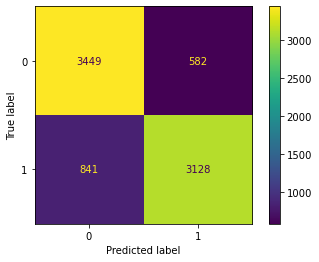

In [13]:
plot_confusion_matrix(nb_model,test_selected,y_test)

# Logistic Regression

Try Logreg with count/tfidf vectors, stemming, n-grams

In [11]:
vectorizer=CountVectorizer(stop_words=stopwords_list,max_features=5000)
tokens_train=vectorizer.fit_transform(X_train).toarray()

logreg=LogisticRegression(max_iter=500)

logreg.fit(tokens_train,y_train)
results=cross_val_score(logreg,tokens_train,y_train)
print(results)
results.mean()

[0.85421875 0.85734375 0.85875    0.8571875  0.86359375]


0.85821875